# Investigator

### Purpose

This notebook is supposed to be an interactive tool to look at parameters and values hidden in the network states. By default you can look at model checkpoints and visualize the different weights

Investigator additionally is capable to read saved model-output (.pkl) files to investigate different parameters and explore plotting and animation of time related properties

### Code

In [1]:
#           ."""-.
#          /      \
#          |  _..--'-.
#          >.`__.-"";"`
#         / /(     ^\
#         '-`)     =|-.
#          /`--.'--'   \ .-.
#        .'`-._ `.\    | J /
#       /      `--.|   \__/
#
#
#
# Copyright 2019 Markus Ernst
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.


# standard libraries
# -----
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from tensorflow.python.training import checkpoint_utils as cu
import pandas as pd
import seaborn as sns

# custom functions
# -----
import visualizer

# Implementation of t-SNE in Python. The implementation was tested on Python
# 2.7.10, and it requires a working installation of NumPy. The implementation
# comes with an example on the MNIST dataset. In order to plot the
# results of this example, a working installation of matplotlib is required.
#
#
#  Created by Laurens van der Maaten on 20-12-08.
#  Copyright (c) 2008 Tilburg University. All rights reserved.



def Hbeta(D=np.array([]), beta=1.0):
    """
        Compute the perplexity and the P-row for a specific value of the
        precision of a Gaussian distribution.
    """

    # Compute P-row and corresponding perplexity
    P = np.exp(-D.copy() * beta)
    sumP = sum(P)
    H = np.log(sumP) + beta * np.sum(D * P) / sumP
    P = P / sumP
    return H, P


def x2p(X=np.array([]), tol=1e-5, perplexity=30.0):
    """
        Performs a binary search to get P-values in such a way that each
        conditional Gaussian has the same perplexity.
    """

    # Initialize some variables
    print("Computing pairwise distances...")
    (n, d) = X.shape
    sum_X = np.sum(np.square(X), 1)
    D = np.add(np.add(-2 * np.dot(X, X.T), sum_X).T, sum_X)
    P = np.zeros((n, n))
    beta = np.ones((n, 1))
    logU = np.log(perplexity)

    # Loop over all datapoints
    for i in range(n):

        # Print progress
        if i % 500 == 0:
            print("Computing P-values for point %d of %d..." % (i, n))

        # Compute the Gaussian kernel and entropy for the current precision
        betamin = -np.inf
        betamax = np.inf
        Di = D[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))]
        (H, thisP) = Hbeta(Di, beta[i])

        # Evaluate whether the perplexity is within tolerance
        Hdiff = H - logU
        tries = 0
        while np.abs(Hdiff) > tol and tries < 50:

            # If not, increase or decrease precision
            if Hdiff > 0:
                betamin = beta[i].copy()
                if betamax == np.inf or betamax == -np.inf:
                    beta[i] = beta[i] * 2.
                else:
                    beta[i] = (beta[i] + betamax) / 2.
            else:
                betamax = beta[i].copy()
                if betamin == np.inf or betamin == -np.inf:
                    beta[i] = beta[i] / 2.
                else:
                    beta[i] = (beta[i] + betamin) / 2.

            # Recompute the values
            (H, thisP) = Hbeta(Di, beta[i])
            Hdiff = H - logU
            tries += 1

        # Set the final row of P
        P[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))] = thisP

    # Return final P-matrix
    print("Mean value of sigma: %f" % np.mean(np.sqrt(1 / beta)))
    return P


def pca(X=np.array([]), no_dims=50):
    """
        Runs PCA on the NxD array X in order to reduce its dimensionality to
        no_dims dimensions.
    """

    print("Preprocessing the data using PCA...")
    (n, d) = X.shape
    X = X - np.tile(np.mean(X, 0), (n, 1))
    (l, M) = np.linalg.eig(np.dot(X.T, X))
    Y = np.dot(X, M[:, 0:no_dims])
    return Y


def tsne(X=np.array([]), no_dims=2, initial_dims=50, perplexity=30.0):
    """
        Runs t-SNE on the dataset in the NxD array X to reduce its
        dimensionality to no_dims dimensions. The syntaxis of the function is
        `Y = tsne.tsne(X, no_dims, perplexity), where X is an NxD NumPy array.
    """

    # Check inputs
    if isinstance(no_dims, float):
        print("Error: array X should have type float.")
        return -1
    if round(no_dims) != no_dims:
        print("Error: number of dimensions should be an integer.")
        return -1

    # Initialize variables
    X = pca(X, initial_dims).real
    (n, d) = X.shape
    max_iter = 1000
    initial_momentum = 0.5
    final_momentum = 0.8
    eta = 500
    min_gain = 0.01
    Y = np.random.randn(n, no_dims)
    dY = np.zeros((n, no_dims))
    iY = np.zeros((n, no_dims))
    gains = np.ones((n, no_dims))

    # Compute P-values
    P = x2p(X, 1e-5, perplexity)
    P = P + np.transpose(P)
    P = P / np.sum(P)
    P = P * 4.									# early exaggeration
    P = np.maximum(P, 1e-12)

    # Run iterations
    for iter in range(max_iter):

        # Compute pairwise affinities
        sum_Y = np.sum(np.square(Y), 1)
        num = -2. * np.dot(Y, Y.T)
        num = 1. / (1. + np.add(np.add(num, sum_Y).T, sum_Y))
        num[range(n), range(n)] = 0.
        Q = num / np.sum(num)
        Q = np.maximum(Q, 1e-12)

        # Compute gradient
        PQ = P - Q
        for i in range(n):
            dY[i, :] = np.sum(np.tile(PQ[:, i] * num[:, i], (no_dims, 1)).T * (Y[i, :] - Y), 0)

        # Perform the update
        if iter < 20:
            momentum = initial_momentum
        else:
            momentum = final_momentum
        gains = (gains + 0.2) * ((dY > 0.) != (iY > 0.)) + \
                (gains * 0.8) * ((dY > 0.) == (iY > 0.))
        gains[gains < min_gain] = min_gain
        iY = momentum * iY - eta * (gains * dY)
        Y = Y + iY
        Y = Y - np.tile(np.mean(Y, 0), (n, 1))

        # Compute current value of cost function
        if (iter + 1) % 10 == 0:
            C = np.sum(P * np.log(P / Q))
            print("Iteration %d: error is %f" % (iter + 1, C))

        # Stop lying about P-values
        if iter == 100:
            P = P / 4.

    # Return solution
    return Y

In [2]:
# interactive mode /eager execution
tf.enable_eager_execution()

In [3]:
def get_list_of_images(list_of_weights, stereo):


    for kernel in list_of_weights:
        kernel_name = kernel[0]
        kernel_value = kernel[1]
        kname = kernel_name.split('/')[1].split('_')[0] + '/kernels'
        receptive_pixels = kernel_value.shape[0].value
        if 'fc' in kname:
            pass
        elif 'conv0' in kname:
            if stereo:
                image.append(
                    tf.compat.v1.summary.image(kname, put_kernels_on_grid(
                        kname, tf.reshape(kernel_value,
                                          [2 * receptive_pixels,
                                              receptive_pixels, -1,
                                              network.
                                              net_params
                                              ['conv_filter_shapes'][0][-1]])),
                                     max_outputs=1))
            else:
                image.append(
                    tf.compat.v1.summary.image(kname, put_kernels_on_grid(
                        kname, kernel_value),
                        max_outputs=1))

        else:
            image.append(
                tf.compat.v1.summary.image(kname, put_kernels_on_grid(
                    kname, tf.reshape(
                        kernel_value, [receptive_pixels, receptive_pixels,
                                 1, -1])), max_outputs=1))

    return image


In [4]:
def get_model_paths():
    pass

[Visualization] conv0_weights grid: 32 = (4, 8)
(1, 20, 40, 1)


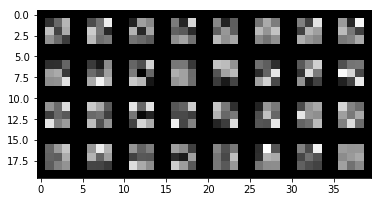

[Visualization] conv1_weights grid: 1024 = (32, 32)
(1, 160, 160, 1)


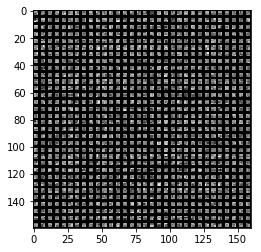

[Visualization] lateral0weights grid: 1024 = (32, 32)
(1, 160, 160, 1)


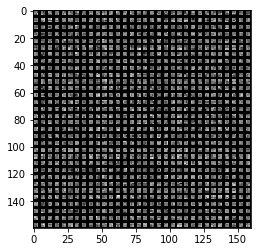

[Visualization] lateral1weights grid: 1024 = (32, 32)
(1, 160, 160, 1)


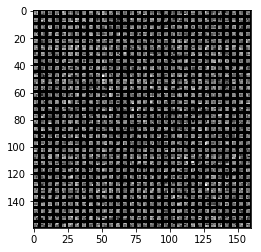

[Visualization] topdown0weights grid: 1024 = (32, 32)
(1, 160, 160, 1)


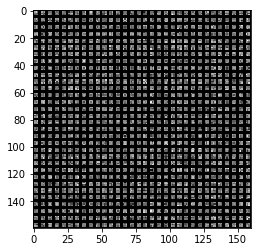

Who would enter a prime number of filters
[Visualization] fc0weights grid: 1 = (1, 1)
(1, 12, 1570, 1)


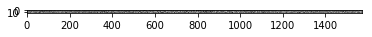

In [5]:
#modelpath = '/Users/markus/Research/Code/saturn/experiments/001_noname_experiment/data/config0/B0_2l_fm1_d1.0_l20.0_bn1_bs100_lr0.003/mnist_2occ_Xp/28x28x1_grayscale_onehot/checkpoints/'
modelpath = '/Users/markus/Research/Code/saturn/experiments/001_noname_experiment/data/config0/BLT3_2l_fm1_d1.0_l20.0_bn1_bs100_lr0.003/mnist_0occ_Xp/28x28x1_grayscale_onehot/checkpoints'

list_of_variables = cu.list_variables(modelpath)
#print(list_of_variables)
#get_list_of_images(list_of_variables, False)

stereo = False
receptive_pixels = 3


def visualize_kernel(kernel, type):
    pass

if stereo:
    conv0weights = cu.load_variable(modelpath, 'convolutional_layer_0/conv0_conv_var')
    viz = visualizer.put_kernels_on_grid(name='conv0_weights', kernel=tf.reshape(conv0weights,[2 * 3, 3, -1, 32]))
    viz_np = viz.numpy()
    print(viz_np.shape)
    plt.imshow(viz_np[0,:,:,0], cmap='gray')
    plt.show()

else:
    conv0weights = cu.load_variable(modelpath, 'convolutional_layer_0/conv0_conv_var')
    conv0weights = tf.convert_to_tensor(conv0weights)
    viz = visualizer.put_kernels_on_grid(name='conv0_weights', kernel=conv0weights)
    viz_np = viz.numpy()
    print(viz_np.shape)
    plt.imshow(viz_np[0,:,:,0], cmap='gray')
    plt.show()

conv1weights = cu.load_variable(modelpath, 'convolutional_layer_1/conv1_conv_var')
conv1weights = tf.convert_to_tensor(conv1weights)
viz = visualizer.put_kernels_on_grid(name='conv1_weights', kernel=tf.reshape(
                        conv1weights, [receptive_pixels, receptive_pixels,
                                 1, -1]))
viz_np = viz.numpy()
print(viz_np.shape)
plt.imshow(viz_np[0,:,:,0], cmap='gray')
plt.show()

lateral0weights = cu.load_variable(modelpath, 'lateral_layer_0/lateral0_var')
lateral0weights = tf.convert_to_tensor(lateral0weights)
viz = visualizer.put_kernels_on_grid(name='lateral0weights', kernel=tf.reshape(
                        lateral0weights, [receptive_pixels, receptive_pixels,
                                 1, -1]))
viz_np = viz.numpy()
print(viz_np.shape)
plt.imshow(viz_np[0,:,:,0], cmap='gray')
plt.show()

lateral1weights = cu.load_variable(modelpath, 'lateral_layer_1/lateral1_var')
lateral1weights = tf.convert_to_tensor(lateral1weights)
viz = visualizer.put_kernels_on_grid(name='lateral1weights', kernel=tf.reshape(
                        lateral1weights, [receptive_pixels, receptive_pixels,
                                 1, -1]))
viz_np = viz.numpy()
print(viz_np.shape)
plt.imshow(viz_np[0,:,:,0], cmap='gray')
plt.show()

topdown0weights = cu.load_variable(modelpath, 'topdown_layer_0/topdown0_var')
topdown0weights = tf.convert_to_tensor(topdown0weights)
viz = visualizer.put_kernels_on_grid(name='topdown0weights', kernel=tf.reshape(
                        topdown0weights, [receptive_pixels, receptive_pixels,
                                 1, -1]))
viz_np = viz.numpy()
print(viz_np.shape)
plt.imshow(viz_np[0,:,:,0], cmap='gray')
plt.show()


fc0weights = cu.load_variable(modelpath, 'fully_connected_layer_0/fc0_fc_var')
fc0weights = tf.convert_to_tensor(fc0weights)
viz = visualizer.put_kernels_on_grid(name='fc0weights', kernel=tf.reshape(
                        fc0weights, [fc0weights.shape[0], fc0weights.shape[1],
                                 1, 1]))
viz_np = np.swapaxes(viz.numpy(),2,1)
print(viz_np.shape)
plt.imshow(viz_np[0,:,:,0], cmap='gray')
plt.show()





In [6]:
kernel_dict = {}

kernel_dict['conv0'] = cu.load_variable(modelpath, 'convolutional_layer_0/conv0_conv_var')
kernel_dict['conv1'] = cu.load_variable(modelpath, 'convolutional_layer_1/conv1_conv_var')
kernel_dict['lat0'] = cu.load_variable(modelpath, 'lateral_layer_0/lateral0_var')
kernel_dict['lat1'] = cu.load_variable(modelpath, 'lateral_layer_1/lateral1_var')
kernel_dict['topdown0'] = cu.load_variable(modelpath, 'topdown_layer_0/topdown0_var')
kernel_dict['fc0'] = cu.load_variable(modelpath, 'fully_connected_layer_0/fc0_fc_var')


In [7]:
#list_of_variables


### Statistics over filters

In [8]:
def standard_stats(kernel):
    print(np.mean(kernel))
    print(np.std(kernel))


    

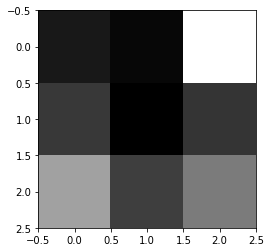

[[[-0.0889203 ]
  [-0.10593209]
  [ 0.13741907]]

 [[-0.05717047]
  [-0.11306254]
  [-0.06055349]]

 [[ 0.04469359]
  [-0.05147279]
  [ 0.00811999]]]


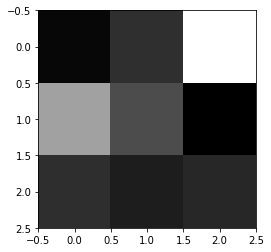

[[[0.37812385]
  [0.38715476]
  [0.43392563]]

 [[0.41281638]
  [0.39357817]
  [0.3765156 ]]

 [[0.38701308]
  [0.38304135]
  [0.3852912 ]]]


In [9]:
spatial_mean = kernel_dict['conv0'].mean(axis=-1)
plt.imshow(spatial_mean[:,:,0], cmap='gray')
plt.show()
print(spatial_mean)

spatial_std = kernel_dict['conv0'].std(axis=-1)
plt.imshow(spatial_std[:,:,0], cmap='gray')
plt.show()
print(spatial_std)




/usr/local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


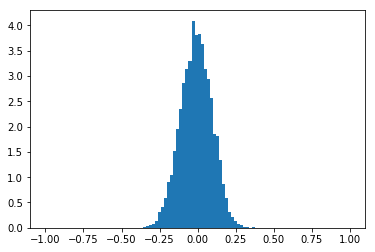

In [40]:
#sparsity? histogram
plt.hist(tf.reshape(kernel_dict['conv1'], [1,-1]), 100, range=[-1, 1], normed=1)
plt.show()

In [24]:
def generate_intercorrelation(weights):
    d = pd.DataFrame(data=np.swapaxes(tf.reshape(weights, [9,-1]).numpy(),0,1))

    # Compute the correlation matrix
    corr = d.corr()

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    return sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

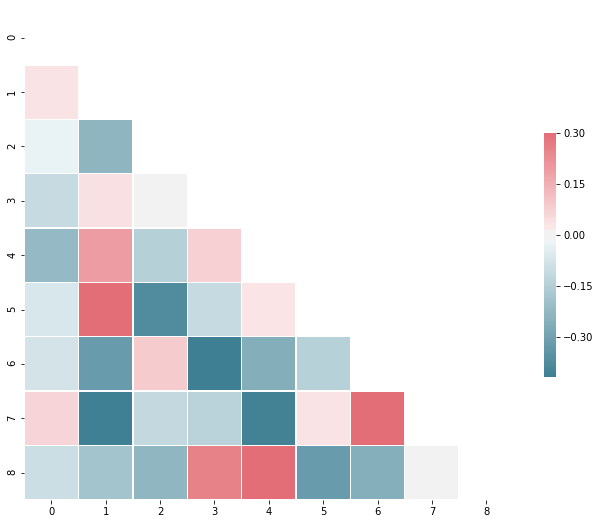

In [26]:
generate_intercorrelation(kernel_dict['conv0'])

Using all PCs, MSE = 8.3733E-16
Using first 20 PCs, MSE = 8.3733E-16


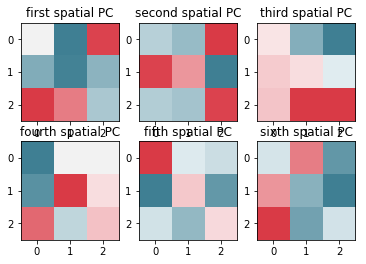

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.misc import ascent

# the underlying signal is a sinusoidally modulated image
img = ascent()
t = np.arange(100)
time = np.sin(0.1*t)
real = time[:,np.newaxis,np.newaxis] * img[np.newaxis,...]

# we add some noise
noisy = real + np.random.randn(*real.shape)*255
noisy = np.moveaxis(np.reshape(kernel_dict['conv0'], [3,3,-1]), -1,0)

# (observations, features) matrix
M = noisy.reshape(noisy.shape[0],-1)

# singular value decomposition factorises your data matrix such that:
# 
#   M = U*S*V.T     (where '*' is matrix multiplication)
# 
# * U and V are the singular matrices, containing orthogonal vectors of
#   unit length in their rows and columns respectively.
#
# * S is a diagonal matrix containing the singular values of M - these 
#   values squared divided by the number of observations will give the 
#   variance explained by each PC.
#
# * if M is considered to be an (observations, features) matrix, the PCs
#   themselves would correspond to the rows of S^(1/2)*V.T. if M is 
#   (features, observations) then the PCs would be the columns of
#   U*S^(1/2).
#
# * since U and V both contain orthonormal vectors, U*V.T is equivalent 
#   to a whitened version of M.

U, s, Vt = np.linalg.svd(M, full_matrices=False)
V = Vt.T

# PCs are already sorted by descending order 
# of the singular values (i.e. by the
# proportion of total variance they explain)

# if we use all of the PCs we can reconstruct the noisy signal perfectly
S = np.diag(s)
Mhat = np.dot(U, np.dot(S, V.T))
print("Using all PCs, MSE = %.6G" %(np.mean((M - Mhat)**2)))

# if we use only the first 20 PCs the reconstruction is less accurate
Mhat2 = np.dot(U[:, :20], np.dot(S[:20, :20], V[:,:20].T))
print("Using first 20 PCs, MSE = %.6G" %(np.mean((M - Mhat2)**2)))

fig, [[ax1, ax2, ax3], [ax4, ax5, ax6]] = plt.subplots(2, 3)
#ax1.imshow(img)
#ax1.set_title('true image')
#ax2.imshow(noisy.mean(0))
#ax2.set_title('mean of noisy images')
ax1.imshow((s[0]**(1./2) * V[:,0]).reshape([3,3]), cmap=cmap)
ax1.set_title('first spatial PC')
ax2.imshow((s[1]**(1./2) * V[:,1]).reshape([3,3]), cmap=cmap)
ax2.set_title('second spatial PC')
ax3.imshow((s[2]**(1./2) * V[:,2]).reshape([3,3]), cmap=cmap)
ax3.set_title('third spatial PC')
ax4.imshow((s[3]**(1./2) * V[:,3]).reshape([3,3]), cmap=cmap)
ax4.set_title('fourth spatial PC')
ax5.imshow((s[4]**(1./2) * V[:,4]).reshape([3,3]), cmap=cmap)
ax5.set_title('fifth spatial PC')
ax6.imshow((s[5]**(1./2) * V[:,5]).reshape([3,3]), cmap=cmap)
ax6.set_title('sixth spatial PC')
plt.show()

In [31]:
# convolve testimage with pc-kernels
# np convolve
np.reshape((s[0]**(1./2) * V[:,0]).reshape([3,3]), [1,3,3,1]).shape

(1, 3, 3, 1)

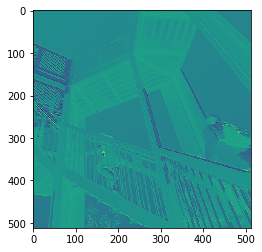

In [32]:
image_input = tf.cast(np.reshape(img, [1,512,512,1]), tf.float32)
conv_kernel = tf.cast(np.reshape((s[0]**(1./2) * V[:,0]).reshape([3,3]), [3,3,1,1]), tf.float32)
convolved_image = tf.nn.conv2d(
    image_input,
    conv_kernel,
    strides=[1,1,1,1],
    padding='SAME')
convolved_image.shape
plt.imshow(convolved_image.numpy()[0,:,:,0])
plt.show()

xyz

In [44]:
print("Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset.")
print("Running example on 2,500 MNIST digits...")
X = np.loadtxt("mnist2500_X.txt")
labels = np.loadtxt("mnist2500_labels.txt")
Y = tsne(X, 2, 50, 20.0)
plt.scatter(Y[:, 0], Y[:, 1], 20, labels)
plt.show()

Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset.
Running example on 2,500 MNIST digits...


OSError: mnist2500_X.txt not found.